In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# pip install scikit-spatial
from skspatial.objects import Point, Line, Plane
from skspatial.plotting import plot_3d

%matplotlib notebook

<IPython.core.display.Javascript object>


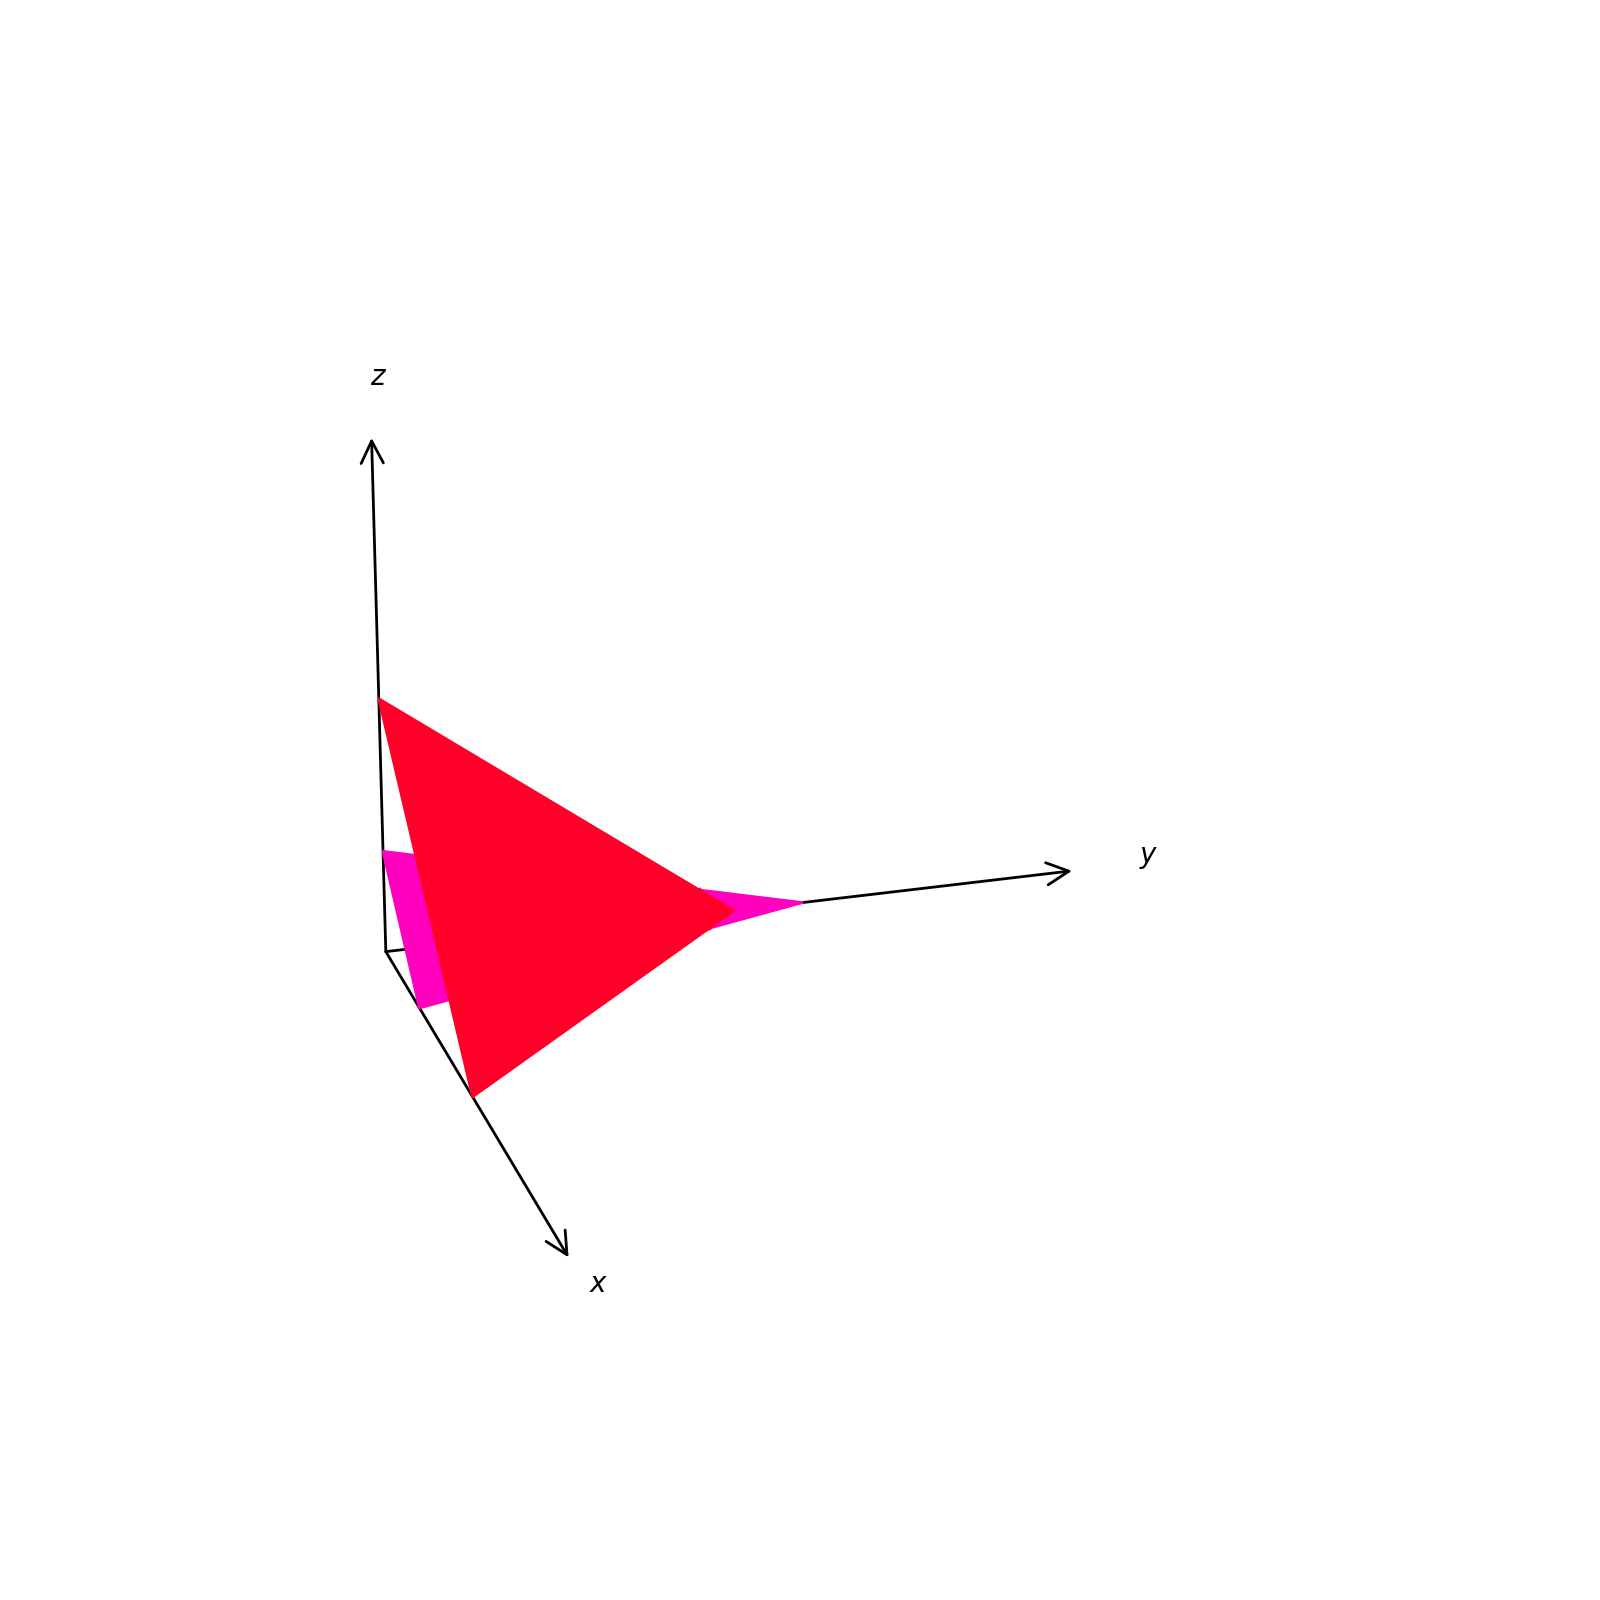

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)


def intersection(plane1, plane2):
    try:
        line = plane1.intersect_plane(plane2)
    except ValueError:
        return None
    
    xy = Plane.from_points((1, 0, 0), (0, 1, 0), (0, 0, 0))
    xz = Plane.from_points((1, 0, 0), (0, 0, 0), (0, 0, 1))
    yz = Plane.from_points((0, 0, 0), (0, 1, 0), (0, 0, 1))
    
    raw_points = []
    for plane in [xy, xz, yz]:
        try:
            ps = plane.intersect_line(line)
            
            outside = False
            
            for p in ps:
                if p > 1 or p < 0 and abs(p) >= 1e-9:
                    outside = True
                    
            if not outside:
                raw_points.append(ps)

        except ValueError:
            pass

    raw_points_n = len(raw_points)
    if raw_points_n >= 2:
        skip_idx = None
        for i in range(raw_points_n):
            for j in range(i + 1, raw_points_n):
                p1 = raw_points[i]
                p2 = raw_points[j]
            
                if p1.distance_point(p2) < 1e-9:
                    skip_idx = j
                    break
    
        points = []
        for i, p in enumerate(raw_points):
            if i != skip_idx:
                points.append(p)
    else:
        points = raw_points
    
    if len(points) == 0:
        return None
    
    if len(points) == 1:
        return points[0]
    
    return Line.from_points(*points)


def mix_colors(color1, color2):    
    res = []
    for v1, v2 in zip(color1, color2):
        res.append((v1 + v2) / 2)
    return res
    
    
def plot(planes, figsize=(8,8), cmap=plt.cm.gist_rainbow, plane_alpha=.2, inter_alpha=1):
    planes_n = len(planes)
    
    fig = plt.figure('MeLiF', figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
    a = Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict)
    ax.add_artist(a)
    a = Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict)
    ax.add_artist(a)
    a = Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict)
    ax.add_artist(a)

    # ax.text(0.0, 0.0, -0.1, r'$0$')
    ax.text(1.1, 0, 0, r'$x$')
    ax.text(0, 1.1, 0, r'$y$')
    ax.text(0, 0, 1.1, r'$z$')

    points = []
    for plane in planes:
        p1 = (plane[0], 0, 0)
        p2 = (0, plane[1], 0)
        p3 = (0, 0, plane[2])    
        points.append([p1, p2, p3])

    colors = cmap(np.linspace(0, 1, planes_n))
        
    for verts, color in zip(points, colors):
        collection = Poly3DCollection(verts, alpha=plane_alpha, color=color)
        ax.add_collection3d(collection)
        
    for i in range(planes_n):
        for j in range(i + 1, planes_n):
            plane1 = Plane.from_points(*points[i])
            plane2 = Plane.from_points(*points[j])
            
            inter = intersection(plane1, plane2)
            if inter is not None:
                color = mix_colors(colors[i], colors[j])
                inter.plot_3d(ax, alpha=inter_alpha, color=color)

#     line = Line.from_points((0, 0, 0), (1, 1, 1))
#     line.plot_3d(ax, alpha=inter_alpha, color='r')

#     verts = [(0, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 0), (0, 0, 1), (0, 1, 1)]
#     collection = Poly3DCollection(verts)
#     collection.set_facecolor('r')
#     collection.set_edgecolor('r')
#     ax.add_collection3d(collection)
    
    plt.axis('off')
    plt.show()

# Input format: [(x_1, y_2, z_1), (x_2, y_2, z_2), ...], where 0 < x_i, y_i, z_i < 1
# See: https://onlinemschool.com/math/library/analytic_geometry/plane/#h3

planes = [(.5, .5, .5), (.2, .6, .2)]
plot(planes, figsize=(8,8), cmap=plt.cm.gist_rainbow, plane_alpha=1, inter_alpha=1)